In [104]:
import s3fs
import xarray as xr
import xesmf
import matplotlib.pyplot as plt 
import numpy as np

In [105]:
## create a list of inputs to loop over 
## these are a names that correspond to the era5 data sets
data_varaibles = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres']
name_variables = [f'T2D',f'PSFC',f'Q2D']

In [106]:
## load in data set of geogrid and then create a subset of curvilinear grid 
## to output the dset data to load
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.milwaukee.nc')

ds_out = xr.Dataset(
    {
        "lat": (["y","x"],geogrid.XLAT_M[0].values),
        "lon": (["y","x"], geogrid.XLONG_M[0].values),
    }
)



In [107]:
fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[0]}.zarr', s3=fs)
dset_t = xr.open_zarr(fmap, consolidated=True)
dset_t

<xarray.Dataset>
Dimensions:                      (time0: 744, lat: 721, lon: 1440)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * time0                        (time0) datetime64[ns] 2010-07-01 ... 2010-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [108]:
## determine the nearest coordinates of the geogrid file, and then add 2 to it to be safe
lonsv, latsv = np.meshgrid(-360+dset_t.lon.values,dset_t.lat.values)
## get the id of the lons from geogrid
LON_start = np.abs(lonsv - ds_out.lon[0,0].values)
LON_end = np.abs(lonsv - ds_out.lon[-1,-1].values)

idx_lonstart = np.where(LON_start == LON_start.min())
idx_lonend = np.where(LON_end == LON_end.min())
input_lonstart = idx_lonstart[1][0]-2
input_lonend = idx_lonend[1][0]+2


## get the id of the lats from geogrid
LAT_start = np.abs(latsv - ds_out.lat[0,0].values)
LAT_end = np.abs(latsv - ds_out.lat[-1,-1].values)

idx_latstart = np.where(LAT_start == LAT_start.min())
idx_latend = np.where(LAT_end == LAT_end.min())
input_latstart = idx_latstart[0][0]+2
input_latend = idx_latend[0][0]-2

In [109]:
## take out the data of interest
dset_subset = dset_t[data_varaibles[0]][:,input_latend:input_latstart,input_lonstart:input_lonend]
dset_subset

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 744, lat: 8, lon: 9)>
dask.array<getitem, shape=(744, 8, 9), dtype=float32, chunksize=(372, 8, 9), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 44.25 44.0 43.75 43.5 43.25 43.0 42.75 42.5
  * lon      (lon) float32 270.8 271.0 271.2 271.5 271.8 272.0 272.2 272.5 272.8
  * time0    (time0) datetime64[ns] 2010-07-01 ... 2010-07-31T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

In [117]:
## create the subset dset
lonsv, latsv = np.meshgrid(-360+dset_subset.lon.values,dset_subset.lat.values)

data_array_input = xr.Dataset(
    {
    name_variables[0]:(["y","x"],dset_subset[:,:,:].values),
    }
    ,coords={
        "lat": (["y","x"],latsv),
        "lon": (["y","x"], lonsv),
    }
)   
data_array_input

<xarray.Dataset>
Dimensions:  (y: 8, x: 9)
Coordinates:
    lat      (y, x) float32 44.25 44.25 44.25 44.25 ... 42.5 42.5 42.5 42.5
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
Dimensions without coordinates: y, x
Data variables:
    T2D      (y, x) float32 295.1 295.2 295.4 295.8 ... 293.6 293.1 293.0 292.9

In [118]:
if name_variables[0] == 'T2D':
    regridder = xesmf.Regridder(data_array_input, ds_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_8x9_114x99.nc 
Reuse pre-computed weights? False 
Input grid shape:           (8, 9) 
Output grid shape:          (114, 99) 
Periodic in longitude?      False

In [119]:
dout = regridder(data_array_input)

In [120]:
dout

<xarray.Dataset>
Dimensions:  (y: 114, x: 99)
Coordinates:
    lon      (y, x) float32 -88.75 -88.74 -88.73 -88.71 ... -87.56 -87.55 -87.54
    lat      (y, x) float32 42.81 42.81 42.81 42.81 ... 43.83 43.83 43.83 43.83
Dimensions without coordinates: y, x
Data variables:
    T2D      (y, x) float32 295.3 295.3 295.3 295.3 ... 292.6 292.6 292.5 292.4
Attributes:
    regrid_method:  bilinear

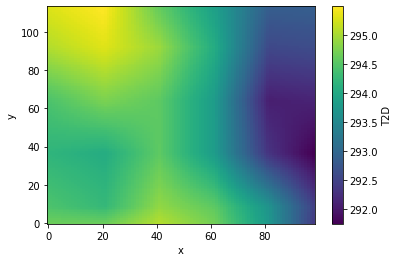

In [121]:
dout.T2D[::-1].plot()

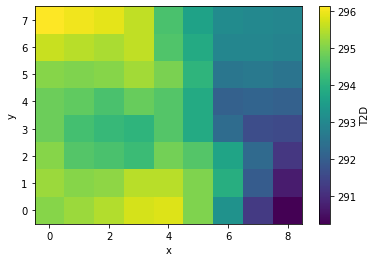

In [122]:
data_array_input.T2D.plot()

<xarray.DataArray 'surface_air_pressure' (y: 8, x: 9)>
array([[     nan,      nan,      nan,      nan,      nan, 297.8125,
        297.6875, 296.5   , 296.5   ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        297.875 , 296.875 , 296.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        295.75  , 296.625 , 296.625 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.375 , 294.75  , 295.9375],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.1875, 293.625 , 294.8125],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 293.875 , 293.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 292.5625, 292.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 291.75  , 292.25  ]], dtype=float32)
Coordinates:
    lat      (y, x) float32 42.5 42.5 42.5 42.5 42.5 ... 44.25 44.25 44.25 44.25
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
Dimensions without coordinates: y, x

In [44]:
dout.surface_air_pressure[0,0]

<xarray.DataArray 'surface_air_pressure' ()>
array(nan, dtype=float32)
Coordinates:
    lon      float32 -88.75
    lat      float32 42.81

In [62]:
## longwave radiation
#s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc

import os
import xarray as xr

variable_name = 'surface_thermal_radiation_downwards'
data_variable = 'strd'
file_name = f'{variable_name}_1980_01-03.nc'

os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name} .')
darr = xr.open_dataset(file_name)[data_variable]
darr

download: s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc to ./surface_thermal_radiation_downwards_1980_01-03.nc


<xarray.DataArray 'strd' (time: 2184, latitude: 721, longitude: 1440)>
[2267516160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 ... 1980-03-31T23:00:00
Attributes:
    units:      J m**-2
    long_name:  Surface thermal radiation downwards